# Exercise 6 - R: Support Vector Machines

<img width="600" src="http://1.bp.blogspot.com/-EGeuaZkSmCY/TtcfqaeCUCI/AAAAAAAADSo/_mkhp4L-3rc/s1600/Kernel_Machine.png">

## *Part I*: Support Vector Machines

In this exercise, we'll fit support vector machines to three unnamed datasets:
1. Linear Separable
2. Non-linear Separable
3. Non-linear Separable


This exercise is a little different than the previous ones because we are moving away from building everything from scratch and towards using existing libraries.  We will be using [e1071](https://cran.r-project.org/web/packages/e1071/index.html) 
to train our support vector machines.


---

Beginning with package imports and data loading

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave matrices
  library(repr)  # Resizing plot sizes in Jupyter
  library(e1071)  # For building SVMs
  library(utils)  # Used for a status bar in lengthy for loops
  library(tidyverse)  # dplyr/tidyr/ggplot
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles
options(repr.plot.width=7, repr.plot.height=4.5)  # Adjusts plot sizes

Warning message:
"package 'R.matlab' was built under R version 3.3.3"Warning message:
"package 'repr' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"

In [2]:
# Loading the matrices for the three data sets
data1 <- readMat('ex6/ex6data1.mat')
data2 <- readMat('ex6/ex6data2.mat')
data3 <- readMat('ex6/ex6data3.mat')

### Linear Separable Data

### Dataset I

Visualizing the data:

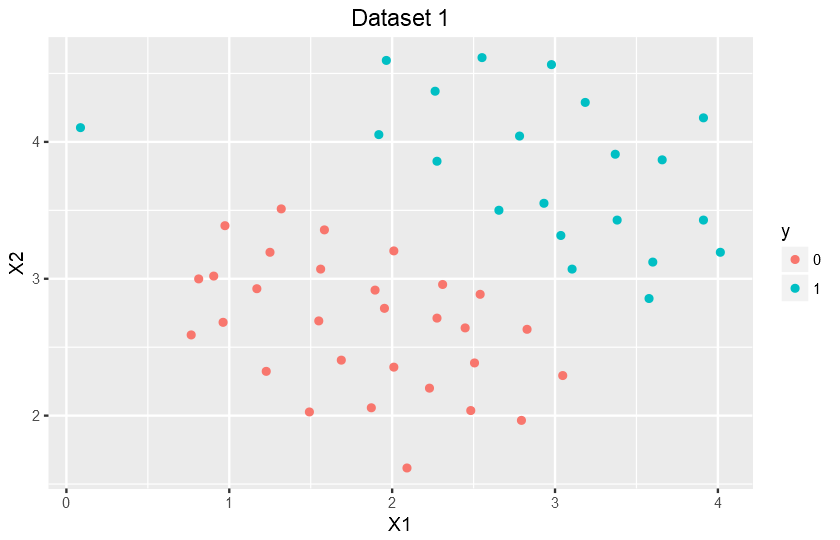

In [3]:
# Assigning X and y for the first data set
X <- data1$X
y <- data1$y
rm(data1)  # Clears from memory

# Putting into a data frame for plots
df <- data.frame(X, y)
df$y <- as.factor(df$y)

# Plotting the original data
ggplot(df) +
  geom_point(aes(x=X1, y=X2, color=y)) +
  ggtitle("Dataset 1")

Notice the outlier in the top left of the graph.  This will largely dictate how our values of C act.  Specifically, if we use a very low value of $C$, the trained support vector machine will be considered a [soft margin classifier](https://nlp.stanford.edu/IR-book/html/htmledition/soft-margin-classification-1.html) and the outlier will be considered a slack variable.  If we use very large values of C, then the trained support vector machine will be considered a [hard margin classifier](https://en.wikipedia.org/wiki/Support_vector_machine#Hard-margin).

#### Fitting and plotting the decision boundary

We'll train the SVM at different values of $C$, and plotting the decision boundary along with the margins.  Here's a typical hard margin support vector machine visual for comparison:

<img src="http://dni-institute.in/blogs/wp-content/uploads/2015/09/SVM-Planes.png">

Notice that the closest points to the decision boundary are called support vectors.  These make support vector machines very memory efficient because you only need to know which samples are support vectors in order to classify additional points in the future.

As a side note, the e1071 package has a decision boundary plot built in, but we'll make our own since it is difficult to discern the points in the positive class:

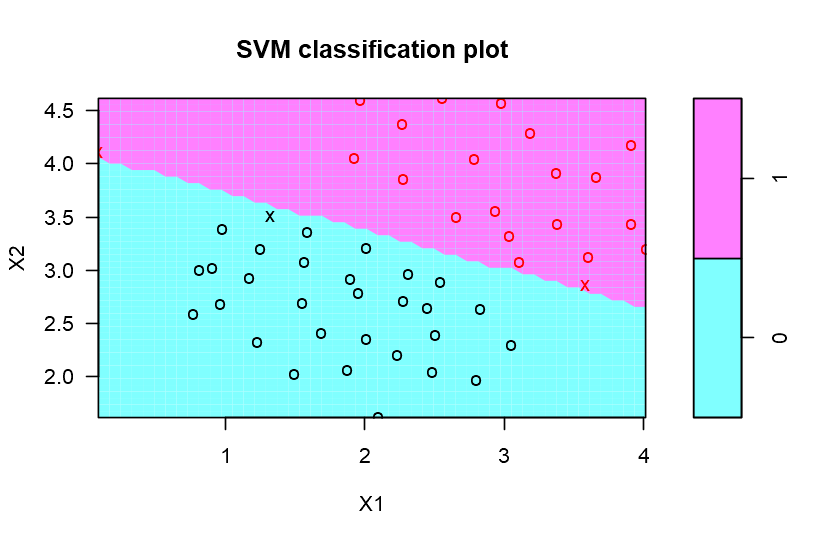

In [4]:
# Fitting the SVM model
model <- svm(y ~ X2 + X1, data=df,
             kernel="linear",
             cost=100)

# Plotting the decision boundary using e1071's function
plot(model, df)

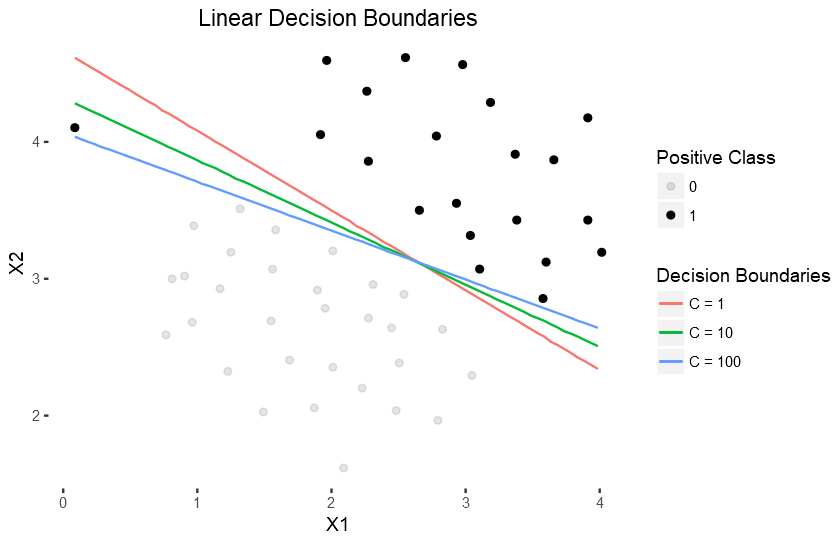

In [5]:
create_boundary <- function(C=1, kernel="linear", gamma=(1/(dim(df)[2]-1))) {
  # Returns a data frame used for plotting the decision boundary
  # Uses the SVM package from the e1071 package
  # Assumes the data frame is titled df
  
  # Fitting the model
  model <- svm(y ~ ., data=df, 
               kernel=kernel, cost=C, gamma=gamma,  # Tuning parameters
               probability=TRUE)  # Outputs class probabilities
  
  # Creating a mesh grid to generate class probabilities for  
  boundary <- data.frame()
  dx <- seq(min(df$X1), max(df$X1), by=0.05)
  dy <- seq(min(df$X2), max(df$X2), length.out=length(dx))

  # Filling the grid with values
  for (i in 1:length(dx)) {
      for (j in 1:length(dx)) {
          v <- t(matrix(c(dx[i], dy[j])))
          boundary <- rbind(boundary, v)
      }
  }
  
  # Generating class probabilities on the polynomial features
  pred <- predict(object=model,
                  newdata=data.frame(X1=boundary[, 1], X2=boundary[, 2]),
                  probability = TRUE)
  boundary$z <- attr(pred, "probabilities")[,1]
  
  return(boundary)
}


# Generating the decision boundaries
C1 <- create_boundary()
C10 <- create_boundary(C=10)
C100 <- create_boundary(C=100)

# Plotting everything
ggplot() +
  geom_point(data=df, aes(x=X1, y=X2,
                          alpha=y)) +  # Using alpha instead of color to clean up legend
  geom_contour(data=C1, aes(x=V1, y=V2, z=z, color='C = 1'), breaks=0.5) + 
  geom_contour(data=C10, aes(x=V1, y=V2, z=z, color='C = 10'), breaks=0.5) + 
  geom_contour(data=C100, aes(x=V1, y=V2, z=z, color='C = 100'), breaks=0.5) +
  labs(alpha='Positive Class', color='Decision Boundaries') + 
  theme(panel.background = element_blank()) +  # To aid in seeing classes 
  ggtitle("Linear Decision Boundaries")

Notice two things about this plot:
    
1. The margins, while not explicitly marked, are significantly wider with lower values of C
2. C $= 100$ correctly the outlier on the upper left side of the graph, but the others misclassify it.  This is because our model is a soft margin classifier with $C \in [1, 10]$, thus making the outlier a slack variable.  When $C = 100$, it is correctly classified, but our margins are tiny.

### SVM with Gaussian Kernels (Non-linear Separable Data)

The [kernel method](https://en.wikipedia.org/wiki/Kernel_method) is a way of finding a linearly separable [hyperplane](https://en.wikipedia.org/wiki/Hyperplane) to separate classes in a nonlinear dataset by mapping it to a higher plane.

<img width="600px" src="http://i2.wp.com/blog.hackerearth.com/wp-content/uploads/2017/02/kernel.png">

[Here](https://www.youtube.com/watch?v=3liCbRZPrZA) is a video demonstrating the kernel method with a polynomial kernel.

I'll create a function for the Gaussian kernel by itself, but e1071's [svm](http://web.mit.edu/~r/current/arch/i386_linux26/lib/R/library/e1071/html/svm.html) has this kernel built in as the 'radial' ([radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function)) kernel.  

### Dataset II

Unlike the other datasets, we are provided with specific parameters for fitting a support vector machine.

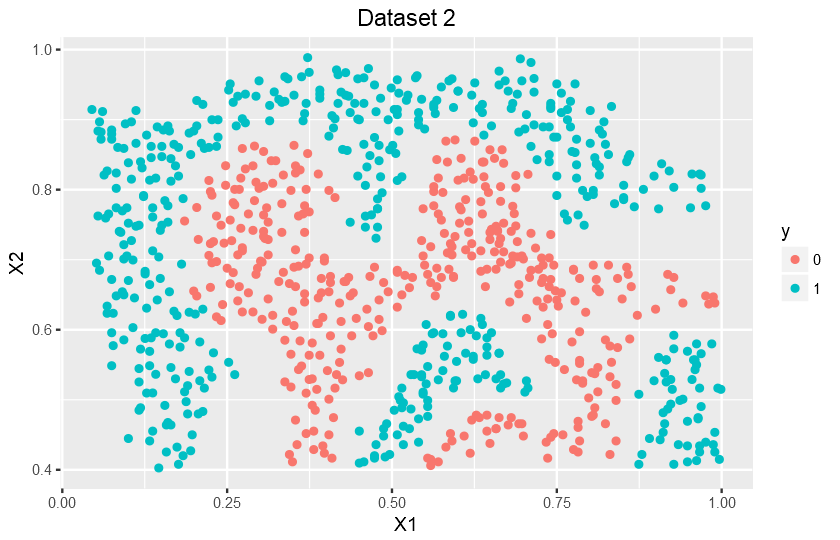

In [6]:
# Assigning X and y for the first data set
X <- data2$X
y <- data2$y
rm(data2)  # Clears from memory

# Putting into a data frame for plots
df <- data.frame(X, y)
df$y <- as.factor(df$y)

# Plotting the original data
ggplot(df) +
  geom_point(aes(x=X1, y=X2, color=y)) +
  ggtitle("Dataset 2")

**Gaussian Kernel**

One way to think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, $(x^{(i)}, x^{(j)})$

$$K_{gaussian}(x^{(i)}, x^{(j)}) = \text{exp} \Big(- \frac{\|x^{(i)} - x^{(j)\|^2}}{2\sigma^2} \Big) = \text{exp} \Bigg(- \frac{\sum_{k=1}^n (x_k^{(i)} - x_k^{(j)})^2}{2\sigma^2} \Bigg)$$

In [7]:
gaussian_kernel <- function(x_i, x_j, sigma=1) {
  # Similarity function to measure the 'distance' between a pair of samples
    
  error <- sum((x_i - x_j)^2)
  return(exp(-(error) / (2*sigma^2)))
}


# Testing values provided by the exercise
test_xi <- c(1.0, 2.0, 1.0)
test_xj <- c(0.0, 4.0, -1.0)
test_sigma <- 2

gaussian_kernel(test_xi, test_xj, test_sigma)

[1] 0.3246525

#### Fitting and plotting the decision boundary

One thing to note is that SVC's gamma parameter takes the place of the sigma parameter in our Gaussian kernel function.  They're in different units, so we just have to multiply the sigmas provided in the exercise by 100.

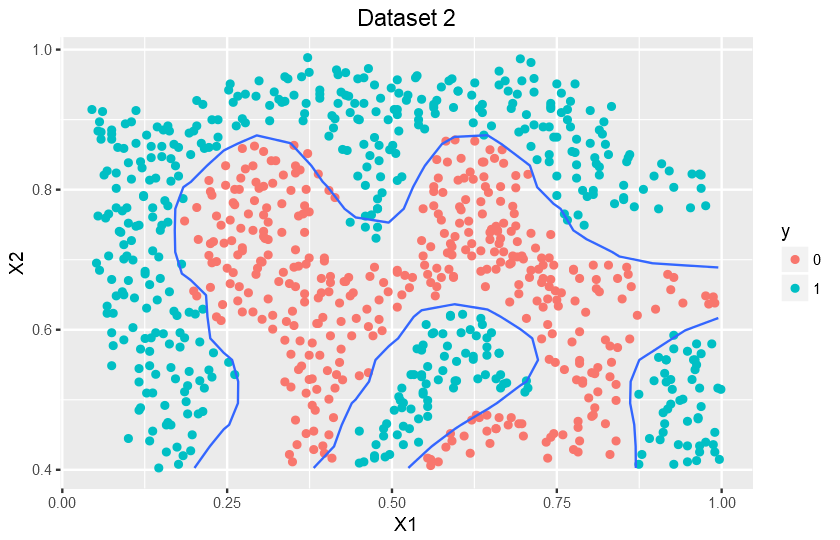

In [8]:
# Calculating the decision boundary
boundary <- create_boundary(C=100, kernel="radial")

# Plotting the original data
ggplot() +
  geom_point(data=df, aes(x=X1, y=X2, color=y)) +
  ggtitle("Dataset 2") +
  geom_contour(data=boundary, aes(x=V1, y=V2, z=z), breaks=0.5)

### Dataset III

Rather than being provided with the parameters for this data set, we're provided with a set of parameters that we must test on the validation set.  In order to find the optimal parameters, we need to try all combinations of the set of parameters with a [grid search](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning).

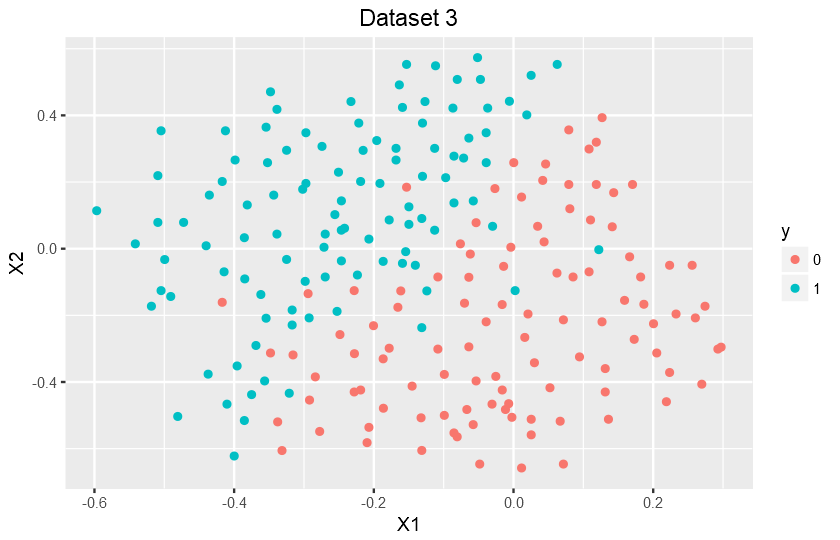

In [9]:
# Assigning X and y for the first data set
X <- data3$X
y <- data3$y
Xval <- data3$Xval
yval <- data3$yval
rm(data3)  # Clears from memory

# Putting into a data frame for plots
df <- data.frame(X, y)
df$y <- as.factor(df$y)

# Plotting the original data
ggplot(df) +
  geom_point(aes(x=X1, y=X2, color=y)) +
  ggtitle("Dataset 3")

#### Grid Search

We're provided with 8 values for $C$ and 8 values for $\sigma$, which results in $8^2 = 64$ combinations.

While there are packages that accomplish this, a simple nested loop will also do.

In [10]:
results <- data.frame(C=NA, sigma=NA, accuracy=NA)

# Looping through possible values
for (C in c(0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30)) {
  for (sigma in c(1, 3, 10, 30, 100, 300, 1000, 3000)) {
    model <- svm(y ~ ., data=df, kernel='radial', cost=C, gamma=sigma)
    prediction <- predict(model, newdata=Xval)
    accuracy <- mean(ifelse(yval == prediction, 1, 0))
    results <- rbind(results, data.frame(C, sigma, accuracy))
  }
}

# Viewing the results
results %>% 
  arrange(desc(accuracy)) %>% 
  head()

C,sigma,accuracy
1.0,3,0.960
1.0,10,0.960
10.0,3,0.960
30.0,1,0.960
0.1,1,0.955
0.3,3,0.955


#### Fitting and plotting the decision boundary

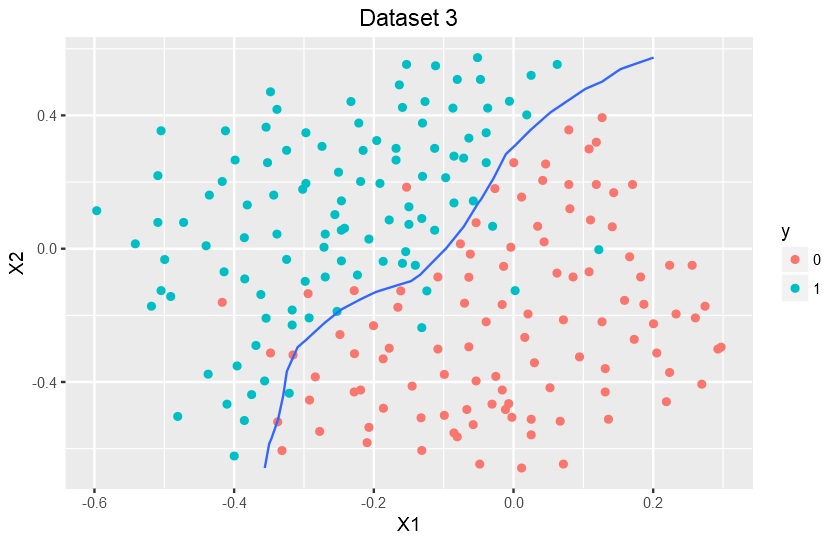

In [11]:
# Calculating the decision boundary
boundary <- create_boundary(C=1, kernel="radial", gamma=3)

# Plotting the original data
ggplot() +
  geom_point(data=df, aes(x=X1, y=X2, color=y)) +
  ggtitle("Dataset 3") +
  geom_contour(data=boundary, aes(x=V1, y=V2, z=z), breaks=0.5)

---

##  *Part II:* Spam Classification

For this part, the email processing has already been accomplished, so we will only be training the model using the processed data.

Before we do, here are processing steps to give a better idea of the data:

1. **Lower-casing (normalizing):** Ignores capitalization to reduce the overall feature space
2. **Stripping HTML:** Removes unnecessary HTML tags
3. **Normalizing URLs:** Changes all URLs to "httpaddr"
4. **Normalizing Email Addresses:** Changes all email addresses to "emailaddr"
5. **Normalizing Numbers:** Changes all numbers to "number"
6. **Normalizing Dollars:** Changes all dollar signs (\$) to "dollar"
7. ** Word Stemming:** Reduces words to their stem (e.x. discounted $\rightarrow$ discount)
8. **Removal of non-words:** Removes punctuation, non-words, and trims white spaces

After that, each result was assigned an index.  Here is an example of the first 20 words along with their indexes:

In [12]:
# Reading in words along with their indexes
vocab <- read_delim("ex6/vocab.txt", "\t", escape_double = FALSE,
                    col_names = FALSE, trim_ws = TRUE)
colnames(vocab) <- c('Idx', 'Word')

# Previewing number of words and first 10 words
print(dim(vocab))
head(vocab, 10)

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_character()
)


[1] 1899    2


Idx,Word
1,aa
2,ab
3,abil
4,abl
5,about
6,abov
7,absolut
8,abus
9,ac
10,accept


Lastly, our training and testing sets were created by one-hot encoding each word:

|X   | 1 (aa) | 2 (ab) | 3 (abil) | 4 (abl) | ... | 1899 (zip) |
|----|--------|--------|----------|---------|-----|------------|  
|1   | 0      | 1      | 0        | 0       | ... | 1          |
|2   | 1      | 0      | 0        | 0       | ... | 0          |
|... | ...    | ...    | ...      | ...     | ... | ...        |
|4000| 0      | 0      | 1        | 0       | ... | 0          |

In [14]:
# Reading in training data
train <- readMat('ex6/spamTrain.mat')
X <- train$X
y <- train$y
rm(train)

# Reading in testing data
test <- readMat('ex6/spamTrain.mat')
Xtest <- test$X
ytest <- test$y
rm(test)

df <- data.frame(X, y)
df$y <- as.factor(df$y)

### Training SVM for Spam Classification

We'll begin with a grid search for finding optimal parameters for our model.  I won't use as many parameters as we did in part I because these models will take significantly longer to fit due to our number of parameters, $n = 1899$ instead of $n=2$.

We'll also use the linear kernel (also known as no kernel) since $n$ (the number of features) is so high.  As a reminder, it is recommended to use the linear kernel when $n$ is high and $m$ (the number of samples) is low, and the Gaussian kernel is recommended when $n$ is small and $m$ is large.

The other advantage of using a linear kernel in this case is that it gives us coefficients which tells us the most used words in spam emails.

In [15]:
startTime <- proc.time()

# Setup for the grid search loop
results <- data.frame(C=NA, accuracy=NA)
pb <- txtProgressBar(min=0, max=7, style=3)  # Status bar
i <- 1  # For counting the status bar

# Looping through hyperparameters and appending accuracy to results df
for (C in c(0.01, 0.1, 1, 10, 30, 100, 300)) {
  # Trains model and checks accuracy against test set
  model <- svm(y ~ ., data=df, kernel='linear', cost=C)
  prediction <- predict(model, newdata=Xtest)
  accuracy <- mean(ifelse(ytest == prediction, 1, 0))
  results <- rbind(results, data.frame(C, accuracy)) 
  
  # Updates status bar
  setTxtProgressBar(pb, i)
  i <- i + 1
}

endTime <- proc.time()  
print(endTime - startTime)

# Viewing the results
results %>% 
  arrange(desc(accuracy)) %>% 
  head()

  |                                                                      |   0%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |==========                                                            |  14%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |====================                                                  |  29%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |==============================                                        |  43%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |========================================                              |  57%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |==================================================                    |  71%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |============================================================          |  86%

Warning message in svm.default(x, y, scale = scale, ..., na.action = na.action):
"Variable(s) 'X814' and 'X890' and 'X1148' and 'X1252' constant. Cannot scale data."

  |======================================================================| 100%   user  system elapsed 
  87.35    2.66   97.63 


C,accuracy
10.0,1.00000
30.0,1.00000
100.0,1.00000
300.0,1.00000
1.0,0.99975
0.1,0.99825
